#### Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

#### Data

In [2]:
cluster_monthly = pd.read_csv("cluster_monthly.csv")

In [3]:
cluster_monthly

,Cluster,date,total_amount
0,0,2010-01-31,1292104.04
1,0,2010-02-28,1227733.58
2,0,2010-03-31,1347335.96
3,0,2010-04-30,1300306.27
4,0,2010-05-31,1333779.14
...,...,...,...
467,3,2019-06-30,1033032.69
468,3,2019-07-31,1061661.16
469,3,2019-08-31,1061982.14
470,3,2019-09-30,1036589.85


#### Holt Winters

In [7]:
def to_month_end(s):
    return pd.to_datetime(s).dt.to_period('M').dt.to_timestamp('M')

def prepare_cluster_series(cluster_monthly, cid, value_col="total_amount"):
    d = cluster_monthly.loc[cluster_monthly["Cluster"] == cid, ["date", value_col]].copy()
    d["date"] = to_month_end(d["date"])
    d[value_col] = d[value_col].astype(str).str.replace(",", "", regex=False).astype(float)
    d = d.sort_values("date")
    y = d.set_index("date")[value_col].asfreq("ME")
    return y

def mape(y, yhat, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100.0

In [8]:
def fit_best_hw(train, s=12, allow_multiplicative=True):
    """
    Try a small grid of HW configs and pick the one with lowest AIC on the train fit.
    Returns the fitted model (on train) and its dict(config).
    """
    positive = (train.min() > 0)
    seasonal_candidates = ["add"]
    if allow_multiplicative and positive:
        seasonal_candidates.append("mul")

    grid = []
    for trend in [None, "add"]:
        for seasonal in seasonal_candidates:
            for damped in [False, True]:
                grid.append(dict(trend=trend, seasonal=seasonal, damped_trend=damped))

    best = None
    best_aic = np.inf
    best_cfg = None

    for cfg in grid:
        try:
            model = ExponentialSmoothing(
                train,
                trend=cfg["trend"],
                damped_trend=cfg["damped_trend"],
                seasonal=cfg["seasonal"],
                seasonal_periods=s,
                initialization_method="estimated",
            )
            res = model.fit(optimized=True, use_brute=False)
            aic = getattr(res, "aic", np.inf)
            if aic < best_aic:
                best_aic, best, best_cfg = aic, res, cfg
        except Exception:
            continue

    return best, best_cfg


def rolling_forecast_holt_winters(ts, window=60, horizon=12, step=12, s=12, allow_multiplicative=True):
    """
    Rolling-window evaluation for Holt-Winters (statsmodels ExponentialSmoothing).
    ts: pd.Series with ME frequency (monthly end).
    Returns dict with MAE, RMSE, MAPE, segments, and chosen configs per step.
    """
    ts = ts.dropna().asfreq("ME")
    n = len(ts)
    preds, actuals = [], []
    segs = []         # list of (DatetimeIndex, np.array forecast)
    cfgs = []         # list of per-window chosen configs

    # need at least two full seasons in the window
    if window < 2 * s:
        return {
            "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan,
            "preds": [], "actuals": [], "segments": [],
            "steps_ran": 0, "notes": f"window < 2*seasonal_periods (window={window}, s={s})"
        }

    if n < window + horizon:
        return {
            "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan,
            "preds": [], "actuals": [], "segments": [],
            "steps_ran": 0, "notes": "series too short for given window/horizon"
        }

    for start in range(0, n - window - horizon + 1, step):
        train = ts.iloc[start : start + window]
        test  = ts.iloc[start + window : start + window + horizon]

        try:
            # pick best config on the current window
            best_fit, best_cfg = fit_best_hw(train, s=s, allow_multiplicative=allow_multiplicative)
            if best_fit is None:
                print(f"Step {start}: no HW config succeeded.")
                continue

            # refit on the same train with the chosen config (best_fit is already fit)
            fc = best_fit.forecast(horizon)
            preds.extend(fc.values)
            actuals.extend(test.values)
            segs.append((test.index, fc.values))
            cfgs.append(best_cfg)

        except Exception as e:
            print(f"Step {start}: Holt-Winters failed → {e}")
            continue

    if len(preds) == 0:
        return {
            "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan,
            "preds": [], "actuals": [], "segments": [],
            "steps_ran": 0, "notes": "no successful folds (see printed errors)"
        }

    mae  = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mp   = mape(actuals, preds)

    return {
        "MAE": mae, "RMSE": rmse, "MAPE": mp,
        "preds": preds, "actuals": actuals,
        "segments": segs, "configs": cfgs,
        "steps_ran": len(segs), "notes": ""
    }

In [9]:
# --- CONFIG (match your previous settings) ---
WINDOW  = 60   # 5 years train
HORIZON = 12   # 12 months forecast
STEP    = 12   # advance 1 year each fold
S       = 12   # monthly seasonality

results_hw = []
results_hw_detail = {}

for cid in sorted(cluster_monthly["Cluster"].unique()):
    y = prepare_cluster_series(cluster_monthly, cid, value_col="total_amount")
    res = rolling_forecast_holt_winters(
        y, window=WINDOW, horizon=HORIZON, step=STEP, s=S, allow_multiplicative=True
    )
    results_hw_detail[cid] = res
    results_hw.append({
        "Cluster": cid,
        "Obs": len(y),
        "Folds": res.get("steps_ran", 0),
        "MAPE": res["MAPE"],
        "MAE": res["MAE"],
        "RMSE": res["RMSE"],
        "Notes": res.get("notes", "")
    })
    print(
        f"Cluster {cid}: folds={res.get('steps_ran', 0)} | "
        f"MAPE={res['MAPE'] if pd.notna(res['MAPE']) else float('nan'):.2f} | "
        f"MAE={res['MAE'] if pd.notna(res['MAE']) else float('nan'):.2f} | "
        f"RMSE={res['RMSE'] if pd.notna(res['RMSE']) else float('nan'):.2f}"
    )

df_results_hw = pd.DataFrame(results_hw).sort_values("Cluster")
df_results_hw

Cluster 0: folds=4 | MAPE=1.17 | MAE=16244.62 | RMSE=20683.60
Cluster 1: folds=4 | MAPE=1.40 | MAE=22507.46 | RMSE=29377.00
Cluster 2: folds=4 | MAPE=1.56 | MAE=23765.85 | RMSE=29204.62
Cluster 3: folds=4 | MAPE=2.08 | MAE=21491.84 | RMSE=26515.24


,Cluster,Obs,Folds,MAPE,MAE,RMSE,Notes
0,0,118,4,1.174537,16244.618426,20683.598088,
1,1,118,4,1.397758,22507.457921,29377.003760,
2,2,118,4,1.555831,23765.849112,29204.622646,
3,3,118,4,2.081832,21491.835927,26515.239196,


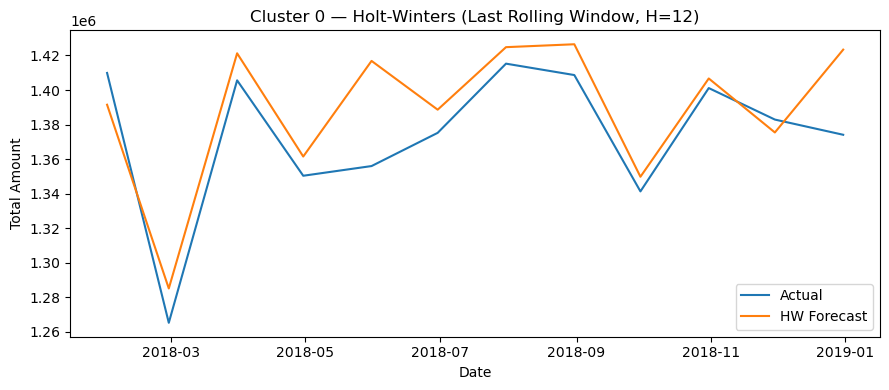

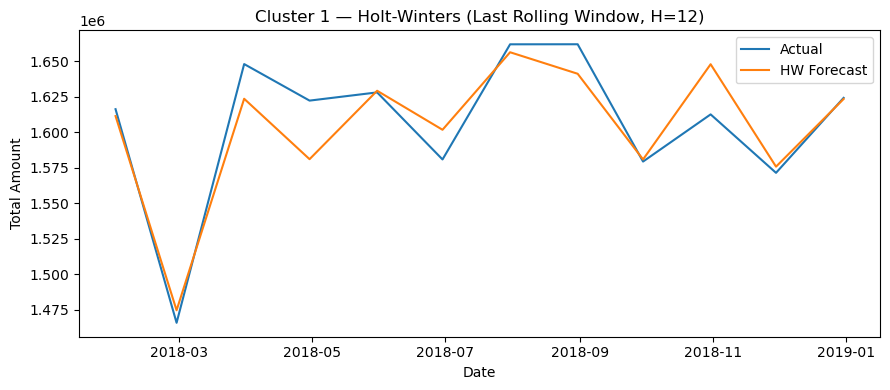

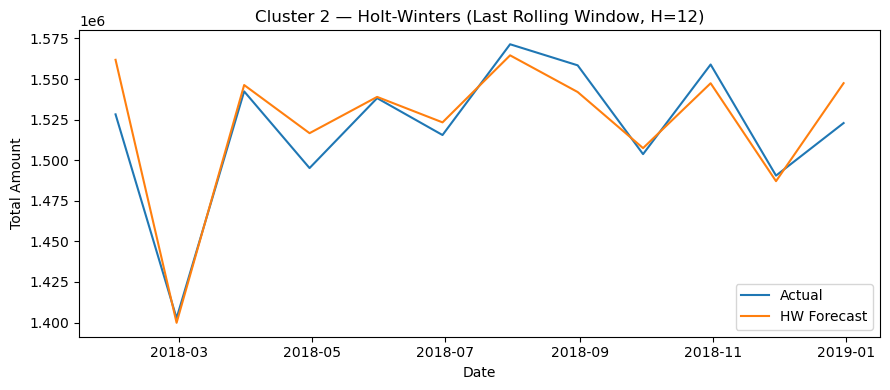

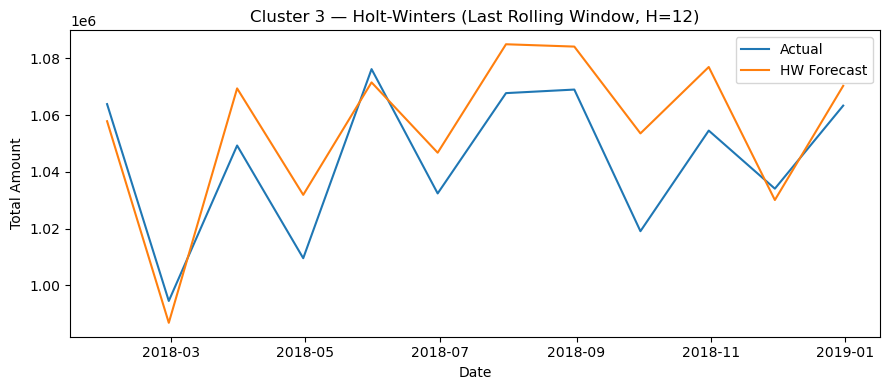

In [11]:
# Last rolling window: Actual vs Forecast per cluster
for cid, res in results_hw_detail.items():
    segs = res.get("segments", [])
    if not segs:
        print(f"Cluster {cid}: no successful folds to plot.")
        continue
    idx, yhat = segs[-1]
    y = prepare_cluster_series(cluster_monthly, cid, value_col="total_amount")
    actual = y.loc[idx]

    plt.figure(figsize=(9,4))
    plt.plot(idx, actual.values, label="Actual")
    plt.plot(idx, yhat, label="HW Forecast")
    plt.title(f"Cluster {cid} — Holt-Winters (Last Rolling Window, H={HORIZON})")
    plt.xlabel("Date"); plt.ylabel("Total Amount")
    plt.legend()
    plt.tight_layout()
    plt.show()